# CNN Explaination

卷积神经网络带的可解释性，以图像分类任务为例，有三种解释方法：

1. **Local Explanation**：图像中的哪些像素对分类结果的影响最大，如 **Saliency Map**。
2. **Global Explanation**：想要获得分类结果应该选择怎样的图像，如 **Activation Maximization**。
3. **Model Explanation**：用一个 interpretable模型 去解释复杂的模型，如 **Local Interpretable Model-Agnostic Explanation(LIME)**。


## Environment settings

In [1]:
# 安装lime库
!pip install lime==0.1.1.37

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## Start our python script

In [2]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

## Argument parsing

In [3]:
# 设置预训练模型和数据路径
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

## Model definition and checkpoint loading

In [4]:
# 模型结构，与预训练模型相同
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.view(out.size()[0], -1)
    return self.fc(out)

In [5]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# 若出现 <All keys matched successfully> 载入成功。

# 若出现 <IncompatibleKeys(missing_keys=[], unexpectd_keys=[])>此输出并不是报错，而是load_state_dict()函数的返回值; 命令其实已执行成功，无需其他处理。

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Dataset definition and creation

In [6]:
# 加载数据集dataset
# 训练train 和测试eval 时使用相同的transform

class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # FoodDataset 继承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定义一个 pytorch dataset 时一定要 implement 的两个 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 这个 method 并不是 pytorch dataset 必要，只是方便我们想要使用「取哪几张图片」出來当作一个 batch 进行 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

    
# 給予 data 的路徑，回傳每一張圖片的「路徑」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 這邊在 initialize dataset 時只丟「路徑」和「class」，之後要從 dataset 取資料時
# dataset 的 __getitem__ method 才會動態的去 load 每個路徑對應的圖片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start Homework 5

### Saliency map

把图像image输入model，经过前向传播得到预测值，与真实label计算出loss。
因此和loss相关的有：
- image
- model parameter
- label

通常情况下，我们通过改变 model parameter 优化模型，在 backward 时计算 **loss 对 model parameter** 的梯度。

Saliency map方法计算  **loss 对 image** 的梯度，这个梯度代表当 model parameter 和 label 固定时，image 的变换会对 loss 产生什么影响。

由于每一个 pixel 都有自己的梯度值，可以把这个值看作该 pixel 的重要性。

因此在同一张图中，画出 loss 对每一个pixel的梯度值，就可以看出图中哪些位置对 model 进行判断是重要的。

在实际操作时，只需要用一行 code 设置 image 需要计算梯度即可。

In [7]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 设置 x 需要计算梯度，通过 backward 计算 x.grad
  x.requires_grad_()
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  saliencies = x.grad.abs().detach().cpu()
  # saliencies: (batches, channels, height, weight)
  # 每张图片的 gradient scale 差距很大，因此对 saliency 做 normalize。
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

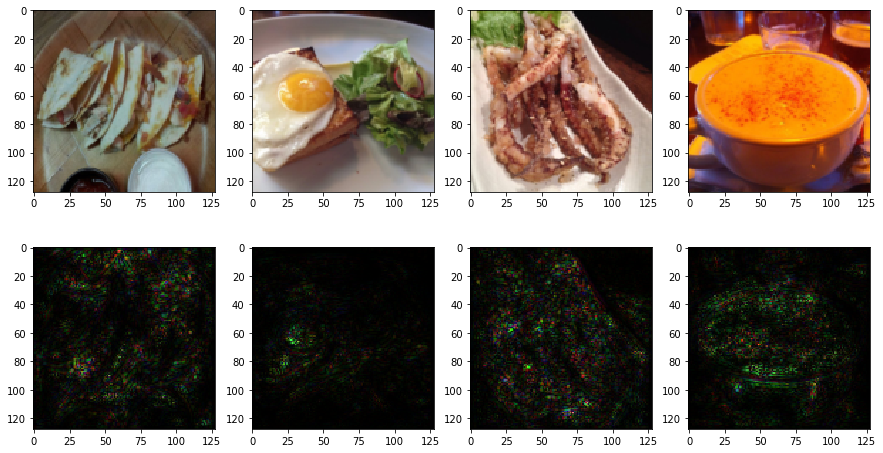

In [8]:
# 指定想要 visualize 的图片编号
img_indices = [83, 4218, 4707, 8598]

images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 绘制 saliency map
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # pytorch 中 image tensor 的 dimension 为 (channels, height, width)
    # matplolib 中 tensor的形状为 (height, width, channels)
    # permute 是 pytorch 中进行 dimension 转换的方法

plt.show()

## Activation Maximization

对网络中的某一个 filter，可以做两件事：
- Filter activation: 图片中的哪些位置能够激活 filter
- Filter visualization: 什么样的 image 能使 filter 最大程度地激活

因此希望计算该 filter 对输入 image 的梯度，对输入图像进行梯度上升。

如何计算某一层中某个 fliter 的梯度？

pytorch 提供了方便的 solution: **hook**。

In [9]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 用来观察的图片
  # cnnid, filterid: 指定第几层 cnn 中第几个 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  # 把模型指定卷积层的 activation map 记录下来
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)

  model(x.cuda())
    
  # 提取指定卷积层的 filter
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
    
  x = x.cuda()
  x.requires_grad_()
  optimizer = Adam([x], lr=lr)

  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    # 计算梯度的量应该是一个标量，因此用 filter 的 sum
    objective = -layer_activations[:, filterid, :, :].sum()
    objective.backward()
    optimizer.step()

  filter_visualization = x.detach().cpu().squeeze()[0]

  # 如果不移除 hook，将一直存在
  hook_handle.remove()

  return filter_activations, filter_visualization

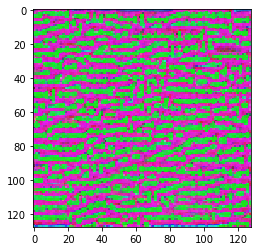

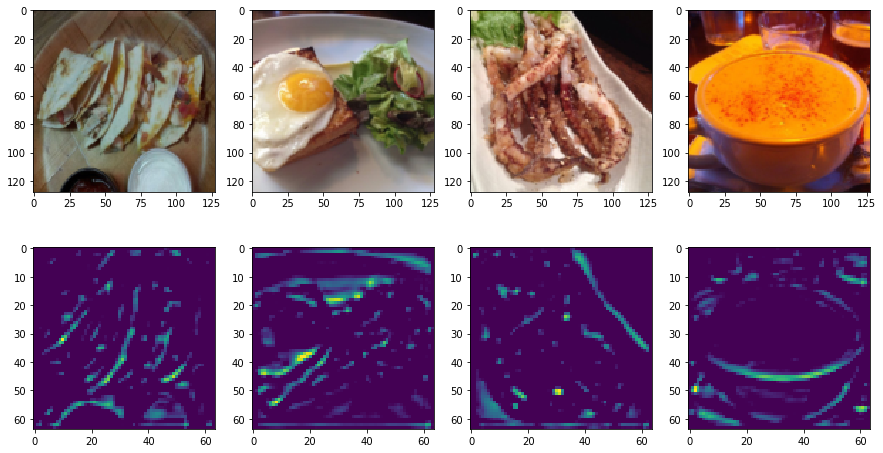

In [10]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# 绘制 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()

# 绘制 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()

## Lime

Python 有现成的 LIME 库，可以直接使用。

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


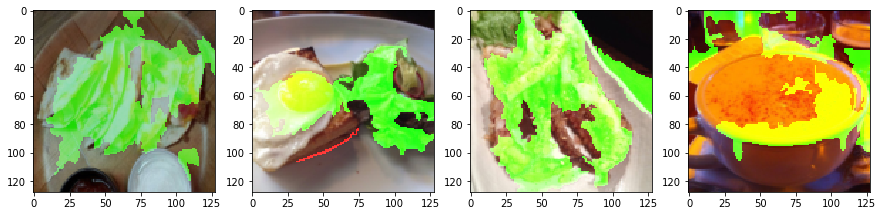

In [11]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 将 input 转成 pytorch tensor，且符合 pytorch 的 dimension 定义
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 将图片分成 100 块                                                                                                                                      
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       

for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # classifier_fn 定义图片经过 model 得到 prediction
    # segmentation_fn 定义图片的 segmentation

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    
    axs[idx].imshow(lime_img)

plt.show()